In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.1"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax.numpy as jnp
import jax
import equinox as eqx

from corrector_src.model._cnn_mhd_corrector import CorrectorCNN
from corrector_src.model._cnn_mhd_corrector_options import (
    CNNMHDParams,
    CNNMHDconfig,
)
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from corrector_src.data.load_sim import (
    load_states,
    integrate_blast,
    filepath_state,
    prepare_initial_state,
)


In [3]:
with initialize(version_base=None, config_path="../../configs"):
    cfg = compose(config_name="config")
    print(cfg)


{'experiment': {'name': 'experiment_1'}, 'data': {'debug': '${training.debug}', 'hr_res': 64, 'downscaling_factor': 2, 'randomizer_1': [0.5, 1.5], 'randomizer_2': [0.5, 1.5], 'randomizer_3': [0.5, 1.5], 'num_snapshots': 80, 'num_checkpoints': 10, 'num_timesteps': 1000, 'generate_data_on_fly': False, 'precomputed_data': True, 'fixed_timestep': False, 'dt_max': 0.1, 't_end': 0.34, 'snapshot_timepoints': [0.2, 0.34], 'use_specific_snapshot_timepoints': True, 'return_snapshots': True}, 'training': {'epochs': 300, 'n_look_behind': 10, 'learning_rate': 0.001, 'return_full_sim': False, 'return_full_sim_epoch_interval': 10, 'rng_key': 60, 'debug': False}, 'models': {'_target_': 'corrector_src.model._cnn_mhd_corrector.CorrectorCNN', 'in_channels': 8, 'hidden_channels': 16}}


# LOAD MODEL

In [4]:
# Create a test model
experiment_folder = "/export/home/jalegria/Thesis/jf1uids/experiments/experiment_1/2025-10-10_15-09-03_10"
model_name = "cnn_model.eqx"
key = jax.random.PRNGKey(42)
model = CorrectorCNN(in_channels=8, hidden_channels=16, key=key)
model = eqx.tree_deserialise_leaves(
    os.path.join(experiment_folder, model_name),
    model,
)
# Test input
test_input = jnp.ones((8, 32, 32, 32))

# Test forward pass
output = model(test_input)
print(f"Output shape: {output.shape}")
print(f"Output norm: {jnp.linalg.norm(output)}")
del output, test_input

Output shape: (8, 32, 32, 32)
Output norm: 197.31899210883918


In [5]:
neural_net_params, neural_net_static = eqx.partition(model, eqx.is_array)
cnn_mhd_corrector_config = CNNMHDconfig(
    cnn_mhd_corrector=True, network_static=neural_net_static
)
cnn_mhd_corrector_params = CNNMHDParams(network_params=neural_net_params)

In [9]:
import numpy as np 
cfg_data = cfg.data
cfg_data.use_specific_snapshot_timepoints = True
cfg_data.snapshot_timepoints = np.linspace(0.0, cfg_data.t_end, 100).tolist()
rng_seed = 112
lr_initial_state, lr_config_corrected, lr_params_corrected, lr_helper_data_corrected, lr_registered_variables_corrected = (
    prepare_initial_state(
        cfg_data=cfg_data,
        rng_seed=rng_seed,
        cnn_mhd_corrector_config=cnn_mhd_corrector_config,
        cnn_mhd_corrector_params=cnn_mhd_corrector_params,
        downscale=True,
    )
)
(
    lr_initial_state,
    lr_config_not_corrected,
    lr_params_not_corrected,
    lr_helper_data_not_corrected,
    lr_registered_variables_not_corrected,
) = prepare_initial_state(
    cfg_data=cfg_data,
    rng_seed=rng_seed,
    cnn_mhd_corrector_config=None,
    cnn_mhd_corrector_params=None,
    downscale=True,
)

hr_initial_state, hr_config, hr_params, hr_helper_data, hr_registered_variables = (
    prepare_initial_state(
        cfg_data=cfg_data,
        rng_seed=rng_seed,
        cnn_mhd_corrector_config=None,
        cnn_mhd_corrector_params=None,
        downscale=False,
    )
)
print(jnp.shape(lr_initial_state), jnp.shape(hr_initial_state))

(8, 32, 32, 32) (8, 64, 64, 64)


In [6]:
import matplotlib.pyplot as plt

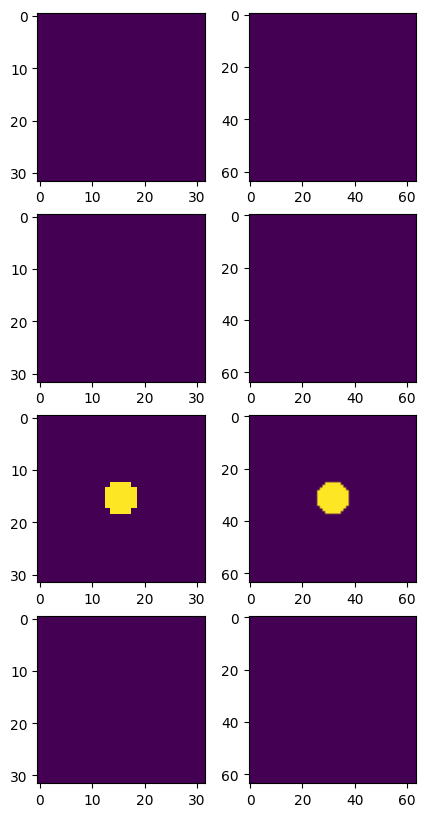

In [10]:
fig, ax = plt.subplots(4, 2, figsize = (5, 10))
#density 0
#velocity 1,2,3
#pressure 4
#magnetic field 5, 6,7
ax[0][0].imshow(lr_initial_state[0, :, :, 16])
ax[0][1].imshow(hr_initial_state[0, :, :, 32])

ax[1][0].imshow(jnp.sqrt(lr_initial_state[1, :, :, 16]**2+ lr_initial_state[2, :, :, 16]**2+ lr_initial_state[3, :, :, 16]**2))
ax[1][1].imshow(
    jnp.sqrt(
        hr_initial_state[1, :, :, 32] ** 2
        + hr_initial_state[2, :, :, 32] ** 2
        + hr_initial_state[3, :, :, 32] ** 2
    )
)

ax[2][0].imshow(lr_initial_state[4, :, :, 16])
ax[2][1].imshow(hr_initial_state[4, :, :, 32])

ax[3][0].imshow(
    jnp.sqrt(
        lr_initial_state[5, :, :, 16] ** 2
        + lr_initial_state[6, :, :, 16] ** 2
        + lr_initial_state[7, :, :, 16] ** 2
    )
)
ax[3][1].imshow(
    jnp.sqrt(
        hr_initial_state[5, :, :, 32] ** 2
        + hr_initial_state[6, :, :, 32] ** 2
        + hr_initial_state[7, :, :, 32] ** 2
    )
)
plt.show()

In [11]:
from jf1uids import time_integration
lr_config_corrected= lr_config_corrected._replace(progress_bar=True)
lr_config_not_corrected = lr_config_not_corrected._replace(progress_bar=True)
hr_config = hr_config._replace(progress_bar=True)
lr_corrected_snapshot_data = time_integration(
    lr_initial_state,
    lr_config_corrected,
    lr_params_corrected,
    lr_helper_data_corrected,
    lr_registered_variables_corrected,
)

lr_not_corrected_snapshot_data = time_integration(
    lr_initial_state,
    lr_config_not_corrected,
    lr_params_not_corrected,
    lr_helper_data_not_corrected,
    lr_registered_variables_not_corrected,
)

hr_snapshot_data = time_integration(
    hr_initial_state, hr_config, hr_params, hr_helper_data, hr_registered_variables
)


 |███████████████████████████████████████████████████████████████████-| 100.0%  
 |███████████████████████████████████████████████████████████████████-| 100.0%  
 |███████████████████████████████████████████████████████████████████-| 100.0%  


In [12]:
from corrector_src.utils.downaverage import downaverage_states

In [13]:
z_level_hr = 16
z_level_lr = 16
hr_states = downaverage_states(hr_snapshot_data.states, cfg.data.downscaling_factor)
lr_corrected_states = lr_corrected_snapshot_data.states
lr_not_corrected_states = lr_not_corrected_snapshot_data.states


In [14]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import jax.numpy as jnp


def plot_and_animate_states(states_list, z_levels, titles=None, vmin=0, vmax=1):
    """
    Plot and animate multiple simulation states (e.g. LR, HR, etc.)

    Args:
        states_list: list of 5D arrays [batch, channel, x, y, z]
        z_levels: list of z-level indices corresponding to each state array
        titles: optional list of titles (e.g. ["LR", "HR"])
        vmin, vmax: normalization range for color scaling
    """

    n_states = len(states_list)
    n_fields = 4  # density, velocity magnitude, pressure, magnetic field

    if titles is None:
        titles = [f"State {i + 1}" for i in range(n_states)]

    fig, axs = plt.subplots(n_states, n_fields, figsize=(5 * n_fields, 5 * n_states))
    if n_states == 1:
        axs = axs[None, :]  # handle single row case

    # Store all imshow handles for animation
    caxs = []

    for row, (states, z_level, title_prefix) in enumerate(
        zip(states_list, z_levels, titles)
    ):
        # --- Field 1: Density ---
        c0 = axs[row][0].imshow(
            states[0, 0, :, :, z_level].T,
            origin="lower",
            norm=plt.Normalize(vmin=vmin, vmax=vmax),
        )
        fig.colorbar(c0, ax=axs[row][0])
        axs[row][0].set_title(f"{title_prefix} - Density")
        axs[row][0].set_xlabel("x")
        axs[row][0].set_ylabel("y")

        # --- Field 2: Velocity magnitude ---
        c1 = axs[row][1].imshow(
            jnp.sqrt(
                states[0, 1, :, :, z_level] ** 2
                + states[0, 2, :, :, z_level] ** 2
                + states[0, 3, :, :, z_level] ** 2
            ).T,
            origin="lower",
            norm=plt.Normalize(vmin=vmin, vmax=vmax),
        )
        fig.colorbar(c1, ax=axs[row][1])
        axs[row][1].set_title(f"{title_prefix} - Velocity Magnitude")

        # --- Field 3: Pressure ---
        c2 = axs[row][2].imshow(
            states[0, 4, :, :, z_level].T,
            origin="lower",
            norm=plt.Normalize(vmin=vmin, vmax=vmax),
        )
        fig.colorbar(c2, ax=axs[row][2])
        axs[row][2].set_title(f"{title_prefix} - Pressure")

        # --- Field 4: Magnetic field magnitude ---
        c3 = axs[row][3].imshow(
            jnp.sqrt(
                states[0, 5, :, :, z_level] ** 2
                + states[0, 6, :, :, z_level] ** 2
                + states[0, 7, :, :, z_level] ** 2
            ).T,
            origin="lower",
            norm=plt.Normalize(vmin=vmin, vmax=vmax),
        )
        fig.colorbar(c3, ax=axs[row][3])
        axs[row][3].set_title(f"{title_prefix} - Magnetic Field")

        # Store for animation
        caxs.append((c0, c1, c2, c3))

    plt.tight_layout()

    # --- Animation function ---
    def animate_all(i):
        updated = []
        for (states, z_level), (c0, c1, c2, c3) in zip(
            zip(states_list, z_levels), caxs
        ):
            c0.set_array(states[i, 0, :, :, z_level].T)
            c1.set_array(
                jnp.sqrt(
                    states[i, 1, :, :, z_level] ** 2
                    + states[i, 2, :, :, z_level] ** 2
                    + states[i, 3, :, :, z_level] ** 2
                ).T
            )
            c2.set_array(states[i, 4, :, :, z_level].T)
            c3.set_array(
                jnp.sqrt(
                    states[i, 5, :, :, z_level] ** 2
                    + states[i, 6, :, :, z_level] ** 2
                    + states[i, 7, :, :, z_level] ** 2
                ).T
            )
            updated.extend([c0, c1, c2, c3])
        return updated

    # Use frame count from first state
    n_frames = states_list[0].shape[0]
    ani = animation.FuncAnimation(fig, animate_all, frames=n_frames, interval=50)

    plt.show()
    html_video = HTML(ani.to_html5_video())
    return html_video


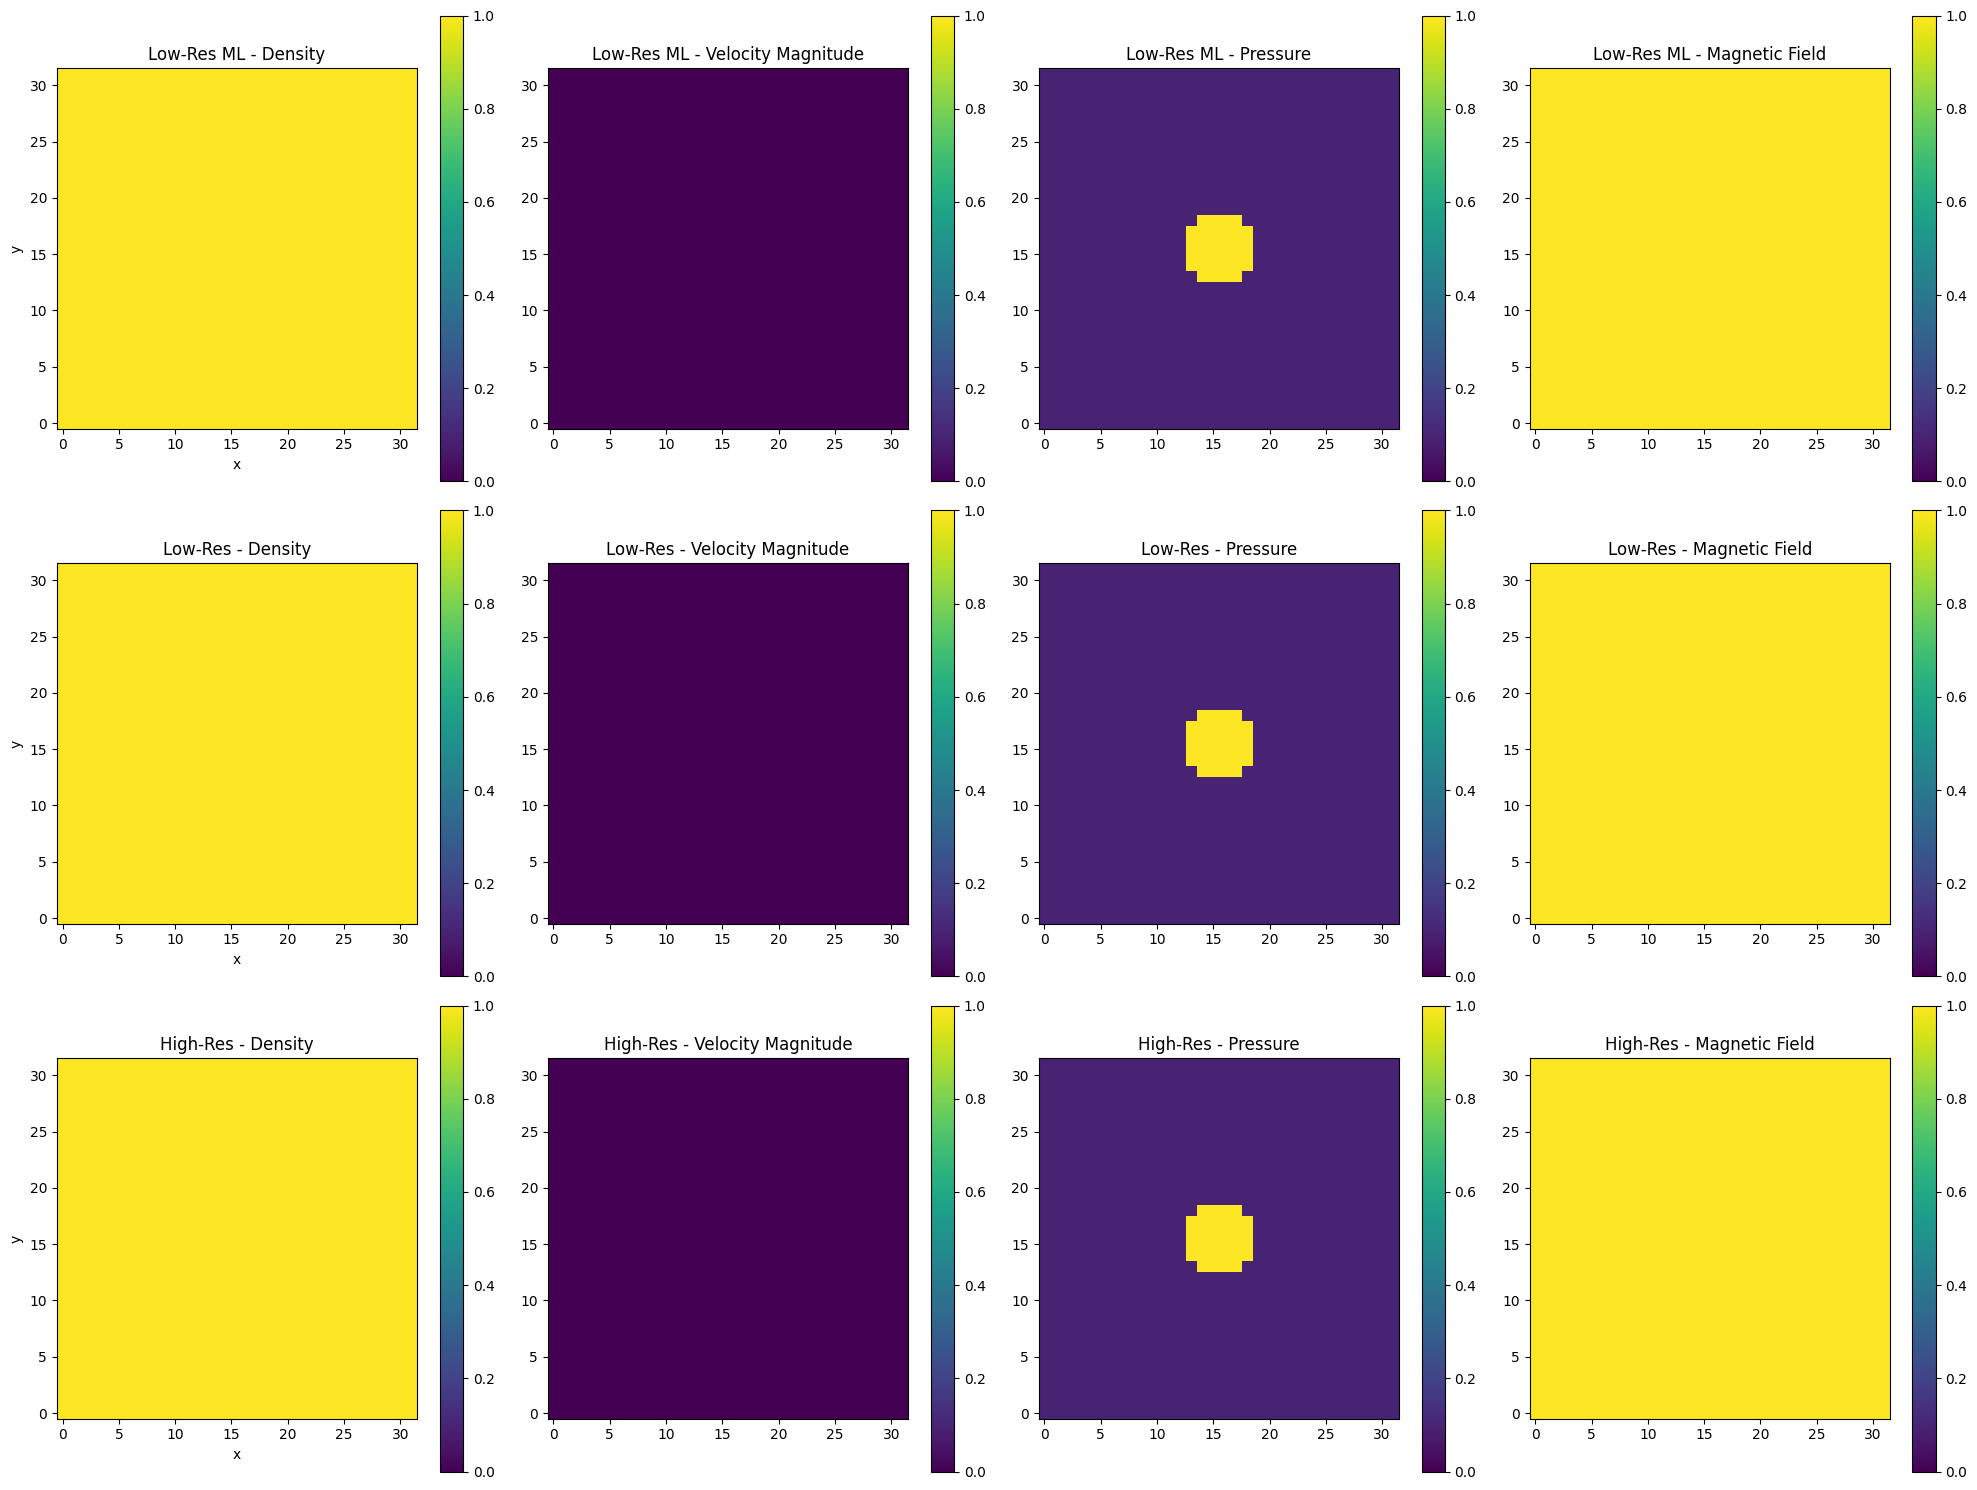

In [15]:
ani_html = plot_and_animate_states(
    states_list=[lr_corrected_states, lr_not_corrected_states, hr_states],
    z_levels=[z_level_lr, z_level_lr, z_level_hr],
    titles=["Low-Res ML","Low-Res", "High-Res"],
)
ani_html


In [16]:
# MSE per snapshot, same as training
loss_lr_hr_corrected = jnp.mean(
    (lr_corrected_states - hr_states) ** 2, axis=(1, 2, 3, 4)
)

loss_lr_lr = jnp.mean(
    (lr_corrected_states - lr_not_corrected_states) ** 2, axis=(1, 2, 3, 4)
)

loss_lr_hr_not_corrected = jnp.mean(
    (lr_not_corrected_states - hr_states) ** 2, axis=(1, 2, 3, 4)
)

losses_training = np.load(
    os.path.join(
        experiment_folder, "losses.npz"
    ), allow_pickle=True
)

with initialize(
    version_base=None,
    config_path="../../experiments/experiment_1/2025-10-10_15-09-03_10/.hydra",
):
    used_config = compose(config_name="config")

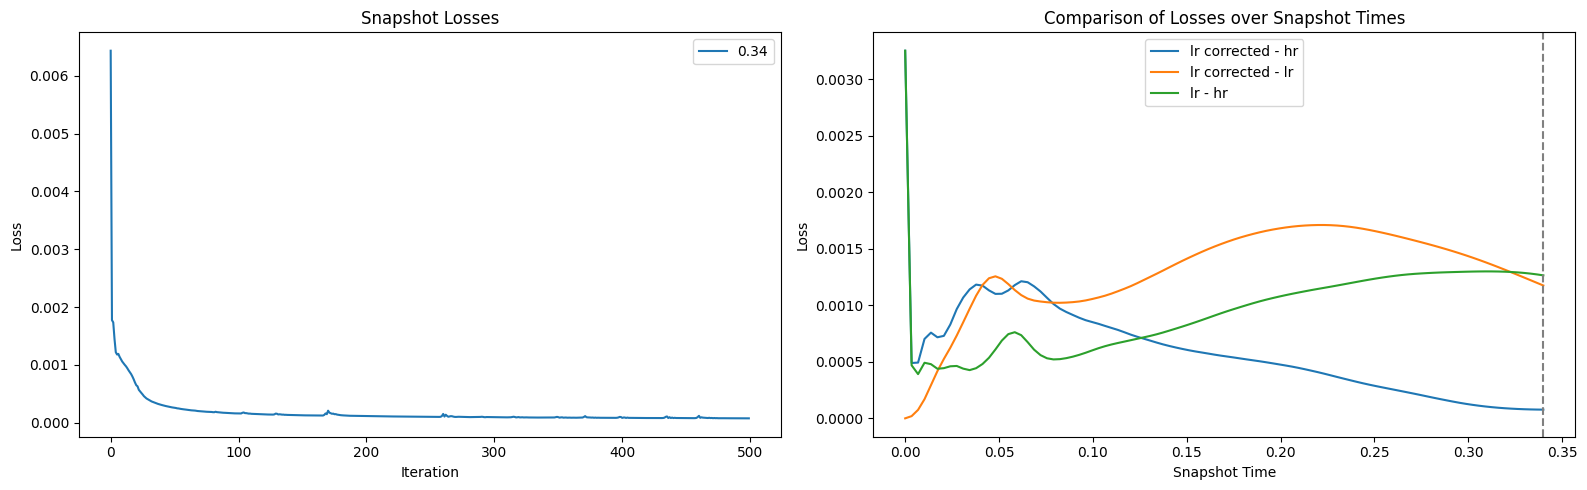

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # adjust figsize as needed

# --- First subplot: snapshot losses ---
used_snapshot_times_training = used_config.data.snapshot_timepoints
snapshot_times = np.array(
    cfg_data.snapshot_timepoints
)  # convert ListConfig to np.array
trained_times_index = []

for i in range(len(used_snapshot_times_training)):
    axs[0].plot(
        losses_training["snapshot_losses"][i::2],
        label=str(used_snapshot_times_training[i]),
    )
    trained_times_index.append(
        np.argmin(np.abs(snapshot_times - used_snapshot_times_training[i]))
    )

axs[0].set_title("Snapshot Losses")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].legend()

# --- Second subplot: comparison losses ---
axs[1].plot(
    cfg_data.snapshot_timepoints, loss_lr_hr_corrected, label="lr corrected - hr"
)
axs[1].plot(cfg_data.snapshot_timepoints, loss_lr_lr, label="lr corrected - lr")
axs[1].plot(cfg_data.snapshot_timepoints, loss_lr_hr_not_corrected, label="lr - hr")

for time in used_snapshot_times_training:
    axs[1].axvline(time, color="gray", linestyle="--")

axs[1].set_title("Comparison of Losses over Snapshot Times")
axs[1].set_xlabel("Snapshot Time")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()


In [19]:
# scalar mean MSE across all snapshots and elements (like training)
scalar_mse_corrected_hr = jnp.mean((lr_corrected_states - hr_states) ** 2)
print("scalar MSE (all snapshots):", scalar_mse_corrected_hr)


scalar MSE (all snapshots): 0.0025633331284128473


In [18]:
# shapes: [snapshots, channels, x, y, z]
def per_snapshot_mse(a, b):
    # returns shape (snapshots,)
    return jnp.mean((a - b) ** 2, axis=(1,2,3,4))

mse_corrected_hr = per_snapshot_mse(lr_corrected_states, hr_states)
mse_notcorr_hr  = per_snapshot_mse(lr_not_corrected_states, hr_states)
mse_corr_not    = per_snapshot_mse(lr_corrected_states, lr_not_corrected_states)

# print the end-time snapshot index and values
n_snap = mse_corrected_hr.shape[0]
end_idx = n_snap - 1
print("per-snapshot MSE (end index)", end_idx, mse_corrected_hr[end_idx], mse_notcorr_hr[end_idx], losses_training["snapshot_losses"][-1])


per-snapshot MSE (end index) 99 7.682726759247792e-05 0.0012641286596114193 7.682335298930676e-05


diff stats at end: 0.08679224746980155 -0.0916970557497381 1.103653958014454e-05 0.008765109570751071


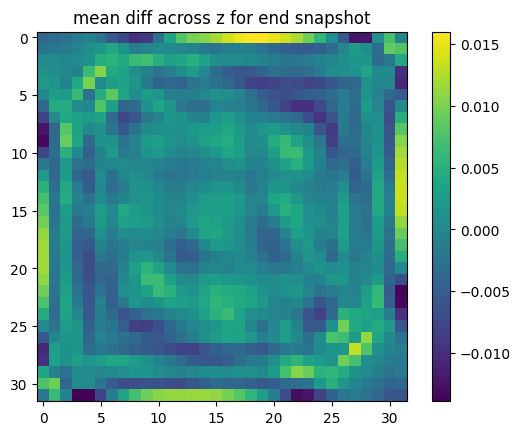

In [ ]:
diff = lr_corrected_states - hr_states
print("diff stats at end:", jnp.max(diff[end_idx]), jnp.min(diff[end_idx]), jnp.mean(diff[end_idx]), jnp.std(diff[end_idx]))
# Optionally plot a slice: (use .squeeze() if needed)
plt.imshow(jnp.mean(diff[end_idx, 0], axis=(2)))  # example: mean across two spatial dims for visualization
plt.colorbar()
plt.title("mean diff across z for end snapshot")
plt.show()


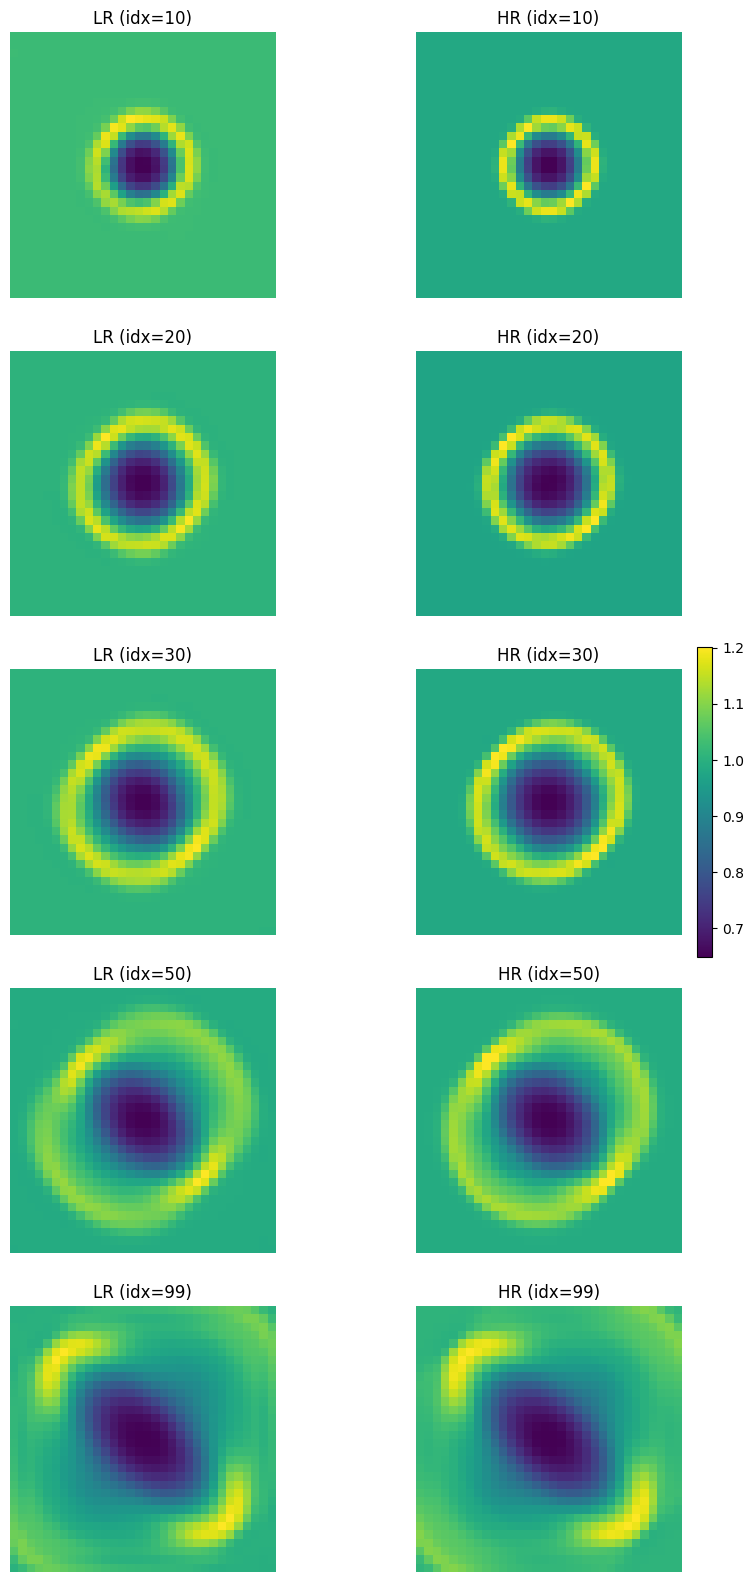

In [36]:
indices = [10, 20, 30, 50, end_idx]  # example vector of indices

fig, ax = plt.subplots(len(indices), 2, figsize=(10, 4 * len(indices)))

vmin = min(jnp.min(lr_corrected_states), jnp.min(hr_states))
vmax = max(jnp.max(lr_corrected_states), jnp.max(hr_states))

for i, idx in enumerate(indices):
    lr_img = jnp.mean(lr_corrected_states[idx, 0], axis=2)
    hr_img = jnp.mean(hr_states[idx, 0], axis=2)

    im1 = ax[i, 0].imshow(lr_img, )
    im2 = ax[i, 1].imshow(hr_img,)

    ax[i, 0].set_title(f"LR (idx={idx})")
    ax[i, 1].set_title(f"HR (idx={idx})")

    # Optional: remove axis ticks for a cleaner look
    for j in range(2):
        ax[i, j].axis('off')

# Add a single shared colorbar
fig.colorbar(im1, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.02)

plt.show()
